In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Investigation of the _Synchronized Brainwave Dataset_

Data set URL: [https://www.kaggle.com/berkeley-biosense/synchronized-brainwave-dataset](https://www.kaggle.com/berkeley-biosense/synchronized-brainwave-dataset)

The data set consists of EEG readings, using a one-channel consumer EEG device called [NeuroSky](http://neurosky.com/), from 30 participants. Two slightly different stimuli were presented to two (mutual exclusive) groups of 15 participants each. The two stiumuli were videos accompanied with voice instructions presenting different tasks, interleaved with phases of relaxation (with eyes shut) and hearing music.
The data from the EEG head bands was collected on a central server that keept track of the latency so that later the **synchronized timestamps** could be computed. Each row in the `eeg-data.csv` file represents one data packet recieved by the server.

## Exploration of the data set

We started with an exploration of the data's shape, the columns, their semantics as stated in the documentation and the data types.

In [2]:
data = pd.read_csv('data/eeg-data.csv')
data.shape

(30013, 13)

Inspecting the shape of the data we get the intuition that we could have around 1000 readings per participant. We can test this using Panda's `value_counts()` function on the id-column

In [3]:
data['id'].value_counts()

17    1607
12    1495
2     1493
8     1465
5     1462
4     1388
14    1297
9     1268
15    1263
10    1224
13    1217
3     1197
28    1180
6     1168
29    1140
11     994
1      940
19     867
7      775
24     688
22     639
20     628
26     623
30     616
25     612
16     606
18     580
23     569
27     548
21     464
Name: id, dtype: int64

This shows that our assumption of roughly a thousand measurments per participant was not correct, there are differences in the number of measurements per participant: from under 500 to around 1500 measurments.

Then we looked at the 13 columns using the `columns` attribute of Pandas dataframes

In [4]:
data.columns

Index(['Unnamed: 0', 'id', 'indra_time', 'browser_latency', 'reading_time',
       'attention_esense', 'meditation_esense', 'eeg_power', 'raw_values',
       'signal_quality', 'createdAt', 'updatedAt', 'label'],
      dtype='object')

A preview of the data in the table can be displayed using the `head` and `tail` functions

In [5]:
data.head(5)

,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
0,3730,12,2015-05-09 23:13:42.281,1461,2015-05-09 16:13:40.954,0,0,"[944412.0, 111373.0, 52404.0, 28390.0, 3237.0,...","[-203.0, -202.0, -196.0, -185.0, -163.0, -137....",200,2015-05-09 23:13:39.550,2015-05-09 23:13:39.549+00,unlabeled
1,3732,12,2015-05-09 23:13:43.186,1461,2015-05-09 16:13:41.964,0,0,"[1793049.0, 89551.0, 3896.0, 21727.0, 9301.0, ...","[104.0, 134.0, 128.0, 121.0, 145.0, 151.0, 123...",200,2015-05-09 23:13:40.559,2015-05-09 23:13:40.559+00,unlabeled
2,3734,12,2015-05-09 23:13:44.392,1461,2015-05-09 16:13:42.950,0,0,"[400192.0, 640624.0, 153087.0, 69733.0, 98854....","[2002.0, 2047.0, 2047.0, 2047.0, 2047.0, 2047....",200,2015-05-09 23:13:41.549,2015-05-09 23:13:41.549+00,unlabeled
3,3735,12,2015-05-09 23:13:45.297,1461,2015-05-09 16:13:43.935,0,0,"[681192.0, 138630.0, 67891.0, 26459.0, 592240....","[1287.0, 1241.0, 1196.0, 1155.0, 1113.0, 1072....",200,2015-05-09 23:13:42.532,2015-05-09 23:13:42.532+00,unlabeled
4,3737,12,2015-05-09 23:13:46.201,1460,2015-05-09 16:13:44.936,0,0,"[268406.0, 197772.0, 190654.0, 266433.0, 91683...","[1905.0, 1836.0, 1770.0, 1707.0, 1645.0, 1587....",200,2015-05-09 23:13:43.532,2015-05-09 23:13:43.532+00,unlabeled


In [6]:
data.tail(5)

,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
30008,10584,17,2015-05-10 00:05:50.380,34,2015-05-09 17:05:51.141,0,0,"[477547.0, 152641.0, 5145.0, 9858.0, 39852.0, ...","[57.0, 12.0, 9.0, 33.0, 50.0, 66.0, 64.0, 52.0...",200,2015-05-10 00:05:51.162,2015-05-10 00:05:51.162+00,unlabeled
30009,10589,17,2015-05-10 00:05:51.389,34,2015-05-09 17:05:52.134,0,0,"[388959.0, 48072.0, 11231.0, 14509.0, 25687.0,...","[21.0, -56.0, -37.0, 25.0, 56.0, 49.0, 23.0, 5...",200,2015-05-10 00:05:52.161,2015-05-10 00:05:52.161+00,unlabeled
30010,10590,17,2015-05-10 00:05:52.366,34,2015-05-09 17:05:53.120,0,0,"[53357.0, 18929.0, 11169.0, 11818.0, 20640.0, ...","[42.0, -4.0, -19.0, 19.0, 53.0, 44.0, 16.0, 4....",200,2015-05-10 00:05:53.144,2015-05-10 00:05:53.144+00,unlabeled
30011,10587,17,2015-05-10 00:05:53.382,34,2015-05-09 17:05:54.142,0,0,"[40891.0, 108300.0, 19622.0, 14285.0, 11863.0,...","[4.0, -24.0, -19.0, 24.0, 55.0, 65.0, 67.0, 58...",200,2015-05-10 00:05:54.167,2015-05-10 00:05:54.167+00,unlabeled
30012,10591,17,2015-05-10 00:05:54.645,34,2015-05-09 17:05:55.140,0,0,"[61861.0, 11302.0, 8251.0, 8788.0, 42668.0, 88...","[-35.0, -81.0, -62.0, 7.0, 80.0, 105.0, 97.0, ...",200,2015-05-10 00:05:55.165,2015-05-10 00:05:55.165+00,unlabeled


From the head and tail calls we got the impression that the `label` field could contain only the value "unlabeled". We used the `unique` function to test this

In [7]:
data['label'].unique()

array(['unlabeled', 'blinkInstruction', 'blink1', 'blink2', 'blink3',
       'blink4', 'blink5', 'relaxInstruction', 'relax', 'mathInstruction',
       'math1', 'math2', 'math3', 'math4', 'math5', 'math6', 'math7',
       'math8', 'math9', 'math10', 'math11', 'math12', 'musicInstruction',
       'music', 'videoInstruction', 'video-ver1',
       'thinkOfItemsInstruction-ver1', 'thinkOfItems-ver1',
       'colorInstruction1', 'colorInstruction2', 'readyRound1',
       'colorRound1-1', 'colorRound1-2', 'colorRound1-3', 'colorRound1-4',
       'colorRound1-5', 'colorRound1-6', 'readyRound2', 'colorRound2-1',
       'colorRound2-2', 'colorRound2-3', 'colorRound2-4', 'colorRound2-5',
       'colorRound2-6', 'readyRound3', 'colorRound3-1', 'colorRound3-2',
       'colorRound3-3', 'colorRound3-4', 'colorRound3-5', 'colorRound3-6',
       'readyRound4', 'colorRound4-1', 'colorRound4-2', 'colorRound4-3',
       'colorRound4-4', 'colorRound4-5', 'colorRound4-6', 'readyRound5',
       'colorRound5

The result showed that there are indeed different values in the label column. The description of the data set saysthat the `label` field contains a label indicating which phase of the stimulus was presented before the measurement was taken. "Unlabeled" are measurements take before and after the stimulus was presented (according to the documentation). 

Another observation we made when looking into the data with `tail` and `head` functions was that all values of the field `signal_quality` are 200. The documentation says that a value of 0 indicates a good signal quality, 128 and more indicate that the participant was wearing the headband in an incorrect way. This was a reason for us investigating the distribution on the `singal_quality` values in the whole dataset. 

We therefor computed the value histogram for the `signal_quality` field. First we used `nunique` to find out the number of different values.

In [8]:
n_bins = data['signal_quality'].nunique()
n_bins

12

Since there are only 12 unique values in this field, we can compute a histogram showing the frequency of all values (not collecting several in bins) using Pandas `hist` function or Seaborn's `histplot` function

Pandas hist plot:
Seaborn histplot:


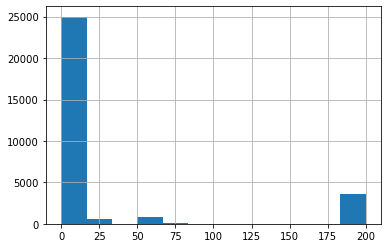

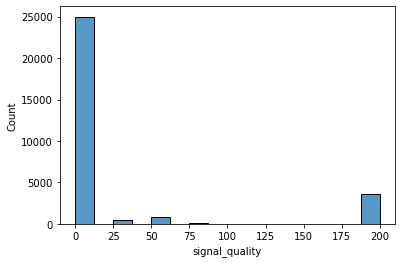

In [12]:
data['signal_quality'].hist(bins=n_bins)
      
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.histplot(data=data, x='signal_quality', ax=ax)

The histogram shows that the situation is actually not so bad. With the `unique` and `value_counts` function we can find out the frequency of the values and compute the percentage for each value.

In [13]:
total = data.shape[0]                          # get total number of rows
values = data['signal_quality'].unique()       # get the individual values
counts = data['signal_quality'].value_counts() # get the counts of all values
for i in range(len(values)):                   # loop trough all values
    value = counts.index[i]                    # get the value's count
    percentage = counts[value] / total * 100   # compute percentage
    print(f"{value}: {percentage:.2f}%") 

0: 83.27%
200: 11.84%
51: 2.49%
26: 0.90%
25: 0.78%
80: 0.46%
54: 0.18%
29: 0.05%
55: 0.01%
27: 0.01%
52: 0.01%
78: 0.01%


This result shows that actually 83% of the measurments are of good quality. Only around 12% are of bad quality. And all other measurements are under the threshold of 128.